# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [1]:
import os

os.makedirs("module", exist_ok=True)

In [2]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary', lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler : Learning Rate Scheduler 객체. dafault: None, Epoch 단위로 LR 를 변경.
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ##################  1 epoch 학습 종료 -> LR 를 변경 ##################
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]   # log 용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0]  # log 용
            if current_lr != new_lr:  # LR 가 변경되었으면
                print(f">>>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<<")



        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [3]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


## utils.py


In [10]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


In [11]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [13]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [14]:
len(train_loader)   # step 수 

235

In [15]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [16]:
len(train_loader.dataset) # 총 데이터 개수

60000

In [17]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

# 모델의 크기 변경에 따른 성능변화


In [18]:
class SmallModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(784, 10) # 입력 -> 출력

    def forward(self, X):
        X = nn.Flatten()(X)  # Batch X 1 X 28 X 28 -> Batch X 784
        output = self.lr(X)
        return output

In [19]:
small_model = SmallModel().to(device)
summary(small_model, (10, 1, 28,28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [10, 10]                  --
├─Linear: 1-1                            [10, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.06

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)
####### LR Scheduler 추가##########
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)

In [ ]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, 
    test_loader, 
    small_model, 
    loss_fn, 
    optimizer, 
    20, # epochs  
    save_model_path="saved_models/small_model.pt",
    device=device, 
    mode="multi",
    lr_scheduler=lr_scheduler
)

Epoch[1/20] - Train loss: 0.48631 Train Accucracy: 0.88003 || Validation Loss: 0.46385 Validation Accuracy: 0.88920
저장: 1 - 이전 : inf, 현재: 0.46384771503508093
Epoch[2/20] - Train loss: 0.38002 Train Accucracy: 0.90018 || Validation Loss: 0.36091 Validation Accuracy: 0.90550
저장: 2 - 이전 : 0.46384771503508093, 현재: 0.3609085474163294
Epoch[3/20] - Train loss: 0.33908 Train Accucracy: 0.90853 || Validation Loss: 0.32453 Validation Accuracy: 0.91150
저장: 3 - 이전 : 0.3609085474163294, 현재: 0.32453365456312894
Epoch[4/20] - Train loss: 0.31615 Train Accucracy: 0.91423 || Validation Loss: 0.30324 Validation Accuracy: 0.91590
저장: 4 - 이전 : 0.32453365456312894, 현재: 0.3032400442287326
>>>>>>>Learning Rate가 0.001에서 0.0005로 변경됨<<<<<<<
Epoch[5/20] - Train loss: 0.30259 Train Accucracy: 0.91682 || Validation Loss: 0.29243 Validation Accuracy: 0.91790
저장: 5 - 이전 : 0.3032400442287326, 현재: 0.29243477191776035
Epoch[6/20] - Train loss: 0.29653 Train Accucracy: 0.91905 || Validation Loss: 0.28700 Validation Acc

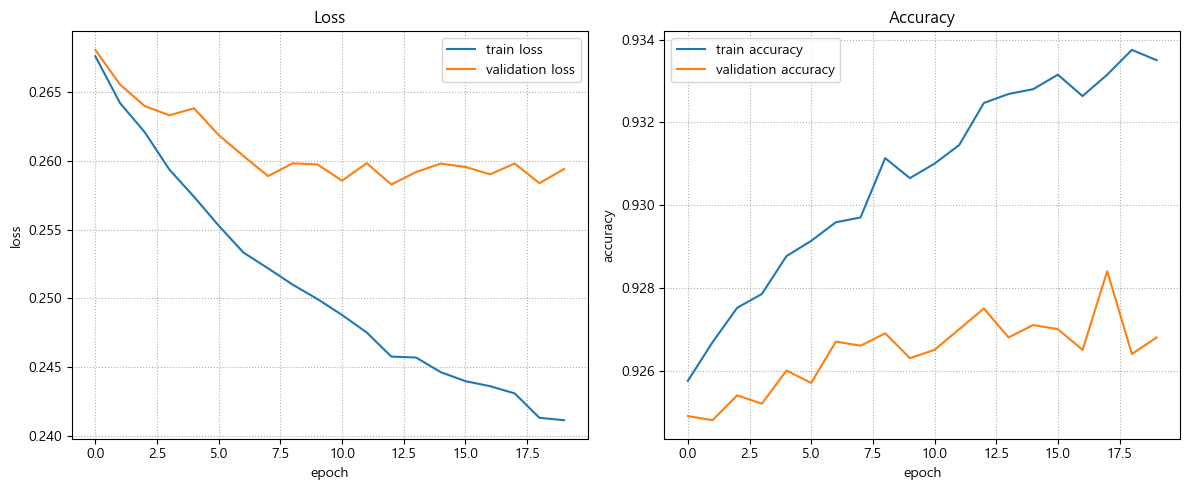

In [18]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [ ]:
# Linear() -> ReLU()
## (Layer) Block -> 규칙적으로 반복되는 Layer들을 묶어서 block으로 설정.
## Block 구현 : 
####  1. class로 구현(복잡한 Block)
####  2. Sequential (단순한 구조의 순차흐름)

In [19]:
b = nn.Sequential(nn.Linear(1, 2), nn.ReLU())
b(torch.randn(10, 1))

tensor([[0.4449, 0.3508],
        [0.0000, 0.0000],
        [0.7830, 0.6863],
        [0.5742, 0.4791],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.2236, 0.1312]], grad_fn=<ReluBackward0>)

In [20]:
# 큰 모델
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Linear() -> ReLU() : Sequential 로 묶어서 정의
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [21]:
big_model = BigModel().to(device)
summary(big_model, (10, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 2048]                --
│    └─Linear: 2-1                       [10, 2048]                1,607,680
│    └─ReLU: 2-2                         [10, 2048]                --
├─Sequential: 1-2                        [10, 1024]                --
│    └─Linear: 2-3                       [10, 1024]                2,098,176
│    └─ReLU: 2-4                         [10, 1024]                --
├─Sequential: 1-3                        [10, 512]                 --
│    └─Linear: 2-5                       [10, 512]                 524,800
│    └─ReLU: 2-6                         [10, 512]                 --
├─Sequential: 1-4                        [10, 256]                 --
│    └─Linear: 2-7                       [10, 256]                 131,328
│    └─ReLU: 2-8                         [10, 256]           

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)


In [ ]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, # dataloader
    big_model, loss_fn, optimizer, epochs,
    save_model_path="saved_models/big_model.pt",
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.15604 Train Accucracy: 0.95597 || Validation Loss: 0.16780 Validation Accuracy: 0.95130
저장: 1 - 이전 : inf, 현재: 0.16780263776890933
Epoch[2/100] - Train loss: 0.10392 Train Accucracy: 0.96927 || Validation Loss: 0.13735 Validation Accuracy: 0.95830
저장: 2 - 이전 : 0.16780263776890933, 현재: 0.13735027268994598
Epoch[3/100] - Train loss: 0.06536 Train Accucracy: 0.98127 || Validation Loss: 0.10734 Validation Accuracy: 0.96940
저장: 3 - 이전 : 0.13735027268994598, 현재: 0.10734455581987276
Epoch[4/100] - Train loss: 0.04424 Train Accucracy: 0.98725 || Validation Loss: 0.09355 Validation Accuracy: 0.97200
저장: 4 - 이전 : 0.10734455581987276, 현재: 0.09355497275246308
Epoch[5/100] - Train loss: 0.02853 Train Accucracy: 0.99155 || Validation Loss: 0.08996 Validation Accuracy: 0.97610
저장: 5 - 이전 : 0.09355497275246308, 현재: 0.08996303047497349
Epoch[6/100] - Train loss: 0.02107 Train Accucracy: 0.99395 || Validation Loss: 0.07748 Validation Accuracy: 0.97990
저장: 6 - 이전 : 0.089963030

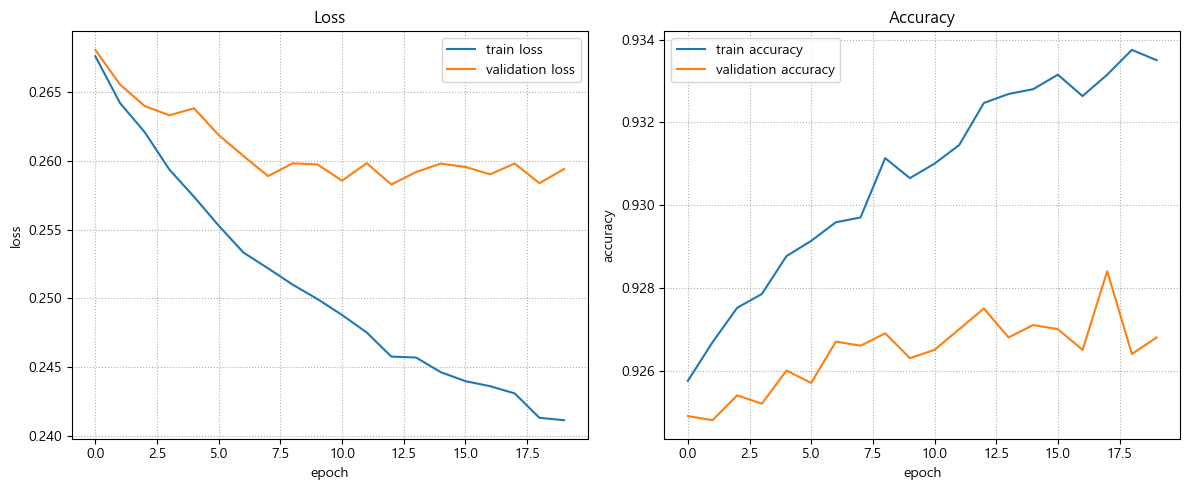

In [23]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [24]:
class DropoutModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear() -> ReLU() -> Dropout()  (앞의 Linear의 파라미터들을 dropout 한다.)
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [25]:
dout_model = DropoutModel().to(device)
summary(dout_model, (10, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [10, 10]                  --
├─Sequential: 1-1                        [10, 2048]                --
│    └─Linear: 2-1                       [10, 2048]                1,607,680
│    └─ReLU: 2-2                         [10, 2048]                --
│    └─Dropout: 2-3                      [10, 2048]                --
├─Sequential: 1-2                        [10, 1024]                --
│    └─Linear: 2-4                       [10, 1024]                2,098,176
│    └─ReLU: 2-5                         [10, 1024]                --
│    └─Dropout: 2-6                      [10, 1024]                --
├─Sequential: 1-3                        [10, 512]                 --
│    └─Linear: 2-7                       [10, 512]                 524,800
│    └─ReLU: 2-8                         [10, 512]                 --
│    └─Dropout: 2-9                      [10, 512]                

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

In [28]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, # dataloader
    dout_model, loss_fn, optimizer, epochs,
    save_model_path="saved_models/dout_model.pt",
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 1.06353 Train Accucracy: 0.49573 || Validation Loss: 1.05635 Validation Accuracy: 0.49350
저장: 1 - 이전 : inf, 현재: 1.056353333592415
Epoch[2/100] - Train loss: 0.64854 Train Accucracy: 0.69462 || Validation Loss: 0.66507 Validation Accuracy: 0.69080
저장: 2 - 이전 : 1.056353333592415, 현재: 0.665071788430214
Epoch[3/100] - Train loss: 0.54435 Train Accucracy: 0.81867 || Validation Loss: 0.55797 Validation Accuracy: 0.82230
저장: 3 - 이전 : 0.665071788430214, 현재: 0.5579659275710582
Epoch[4/100] - Train loss: 0.40002 Train Accucracy: 0.91497 || Validation Loss: 0.45722 Validation Accuracy: 0.91590
저장: 4 - 이전 : 0.5579659275710582, 현재: 0.45721504986286166
Epoch[5/100] - Train loss: 0.33621 Train Accucracy: 0.92193 || Validation Loss: 0.36208 Validation Accuracy: 0.92030
저장: 5 - 이전 : 0.45721504986286166, 현재: 0.36207650043070316
Epoch[6/100] - Train loss: 0.25155 Train Accucracy: 0.94780 || Validation Loss: 0.30777 Validation Accuracy: 0.94280
저장: 6 - 이전 : 0.36207650043070316, 

# Batch Normalization

-   Dense => BN => Activation


In [30]:
# 평균 : 0 , 표준편차:1  변환 -> Normalization(정규화)
class BatchNormtModel(nn.Module):
    # Dense(WX + b) -> BatchNorm(Scaling) -> Activation -> Dropout

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear() -> ReLU() -> Dropout()  (앞의 Linear의 파라미터들을 dropout 한다.)
        self.b1 = nn.Sequential(
            nn.Linear(784, 2048),  # Fully Connected Layer (Dense Layer) -> 파라미털을 이용해서 Feature추출하는 역할
            nn.BatchNorm1d(2048),   # 입력/출력 의 feature 개수. 값이 1차원 1d
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate)
        )

        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [31]:
bn_model = BatchNormtModel().to(device)
summary(bn_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormtModel                          [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Linear: 2-1                       [100, 2048]               1,607,680
│    └─BatchNorm1d: 2-2                  [100, 2048]               4,096
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─BatchNorm1d: 2-6                  [100, 1024]               2,048
│    └─ReLU: 2-7                         [100, 1024]               --
│    └─Dropout: 2-8                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-9                       [100, 512]              

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [32]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)

In [35]:
# optimizer 객체의 attribute 들을 묶어서 제공.
info = optim.param_groups
info_dict = info[0]
print(type(info), type(info_dict))
info_dict.keys()

<class 'list'> <class 'dict'>


dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [36]:
# 현재 lr 값을 조회.
info_dict['lr']

0.001

In [50]:
# Learning 스케쥴러(학습도중 Lr 를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.
import matplotlib.pyplot as plt
def plot_lr(title, lr_list):
    plt.figure(figsize=(10,4))
    plt.plot(range(len(lr_list)), lr_list)


    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0]  # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

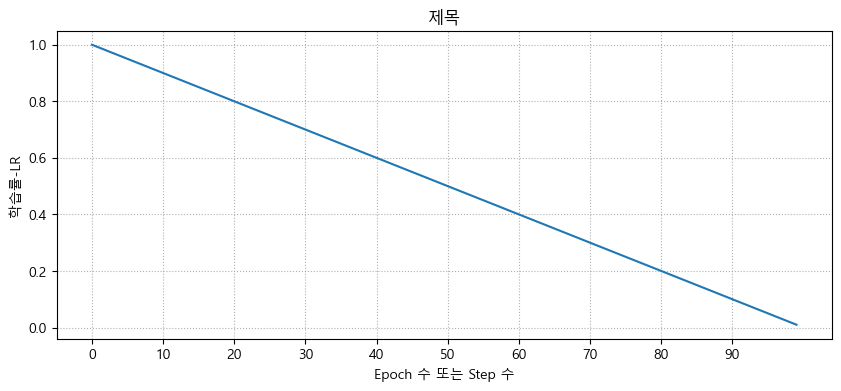

In [51]:
import numpy as np
plot_lr("제목", np.arange(1, 0.001, -0.01))

#### StepLR


In [52]:
# StepLR - 계단 형태로 LR를 변경. 특정 epoch(step) 마다 lr를 특정 비율만큼 변경.
#### 학습 : 모델, Loss 함수, Optimizer (LR 스케쥴러)

optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)
# StepLR 생성
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optim,   # 변경한 LR를 가지고 있는 Optimizer
    step_size = 30,  # 몇번당 변경할지 단위(epoch / step)를 지정함. ( lr_sch.step()-> 몇번 호출하면 변경할지.)
    gamma=0.5,  # 변경 비율. 새_lr = 현재_lr * gamma
)

## 현재 optimizer 의 LR을 조회
optim.param_groups[0]['lr'], step_lr_scheduler.get_last_lr()

(0.001, [0.001])

In [53]:
################## (모델없이) Train 

epochs = 300
step_size = 10    # 1 epoch당 step수.
lr_list = []      # epoch 별 optimizer의 lr를 저장할 리스트.

# 전체 학습
for epoch in range(epochs):
    # 1 epoch 학습   for x, y in dataloader
    for _ in range(step_size):
        # 1 step 학습 -> x,y device 이동 -> 모델 추론 -> loss 계산 -> gradient 계산 -> parameter update -> gradient 초기화.
        # parameter update
        optim.step()
        # 초기화
        optim.zero_grad()
        # LR 를 변경 요청 - 1 step에 끝나면 변경요청 -> [30 step당] 변경.  ## 함수 위치에 따라 단위가 달라진다. 
        # step_lr_scheduler.step()

    # LR 를 변경 요청 - 1 epoch에 끝나면 변경요청 -> [30 epoch당] 변경.
    step_lr_scheduler.step()
    lr_list.append(step_lr_scheduler.get_last_lr()[0])




In [54]:
lr_list

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.0005,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.00025,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,


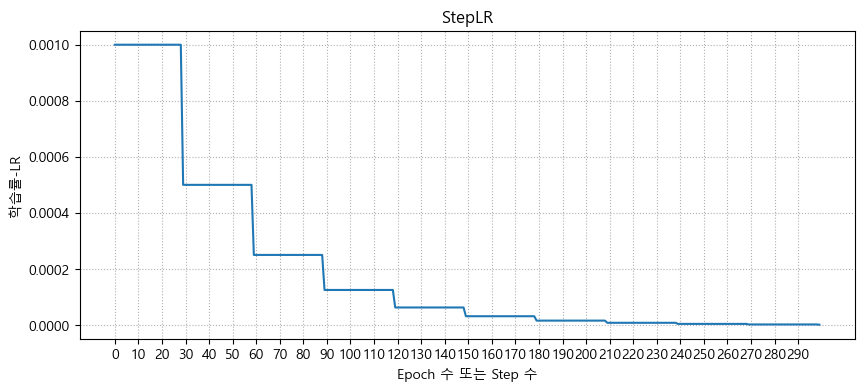

In [55]:
plot_lr("StepLR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [56]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,        # lr 를 변경할 oprimizer
    T_max=10,     # 변화 주기(T_max step/epoch 주기로 최대->최소,  최소->최대)
    eta_min=1e-6  # lr의 최소값.    최대값 : 초기lr 값이 된다(0.001)
)

# 1e-6  = 0.000001  주기: 0.001 <-> 0.000001

In [59]:
lr_list2 = []
for epoch in range(epochs):
    for _ in range(step_size):
        #........학습
        optim.step()
        optim.zero_grad()
    ca_lr_scheduler.step()    # lr 업데이트 (epoch 단위.)
    lr_list2.append(ca_lr_scheduler.get_last_lr()[0])

In [60]:
lr_list2

[0.0009046039886903599,
 0.0007940987335201552,
 0.0006548539886903397,
 0.0005005000000000405,
 0.0003461460113097412,
 0.00020690126647992537,
 9.639601130972036e-05,
 2.5447270110574135e-05,
 1e-06,
 2.5447270110570814e-05,
 9.63960113097161e-05,
 0.00020690126647991634,
 0.00034614601130971947,
 0.000500500000000019,
 0.0006548539886903117,
 0.0007940987335201214,
 0.0009046039886903173,
 0.0009755527298894642,
 0.0010000000000000365,
 0.0009755527298894651,
 0.0009046039886903194,
 0.0007940987335201245,
 0.0006548539886903154,
 0.000500500000000023,
 0.00034614601130973,
 0.00020690126647991951,
 9.639601130972261e-05,
 2.5447270110572037e-05,
 1e-06,
 2.5447270110570814e-05,
 9.639601130971399e-05,
 0.0002069012664799045,
 0.00034614601130971453,
 0.0005004999999999937,
 0.0006548539886902799,
 0.0007940987335200783,
 0.0009046039886902801,
 0.0009755527298894209,
 0.0009999999999999935,
 0.0009755527298894245,
 0.0009046039886902827,
 0.0007940987335200819,
 0.00065485398869028

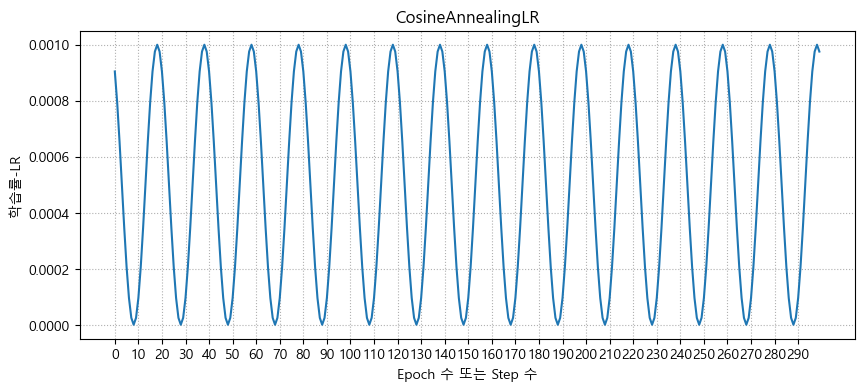

In [61]:
plot_lr("CosineAnnealingLR", lr_list2)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [63]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=10,   # 변화주기 (epoch /step)
    T_mult=2, # 새로운 T_0 를 생성하며, 현재 T_0 * T_mult (한 주기가 끝나면 새로운 주기를 계산.)
    eta_min=1e-6  # 주기 최대 lr: 초기값, 주기최소 lr: eta_min
)

In [67]:
lr_list3 = []
for epoch in range(epochs):
    for _ in range(step_size):
            #........ 학습
        optim.step()
        optim.zero_grad()
    cawr_lr_scheduler.step()  # lr 업데이트. 단위: epoch
    lr_list3.append(cawr_lr_scheduler.get_last_lr()[0])

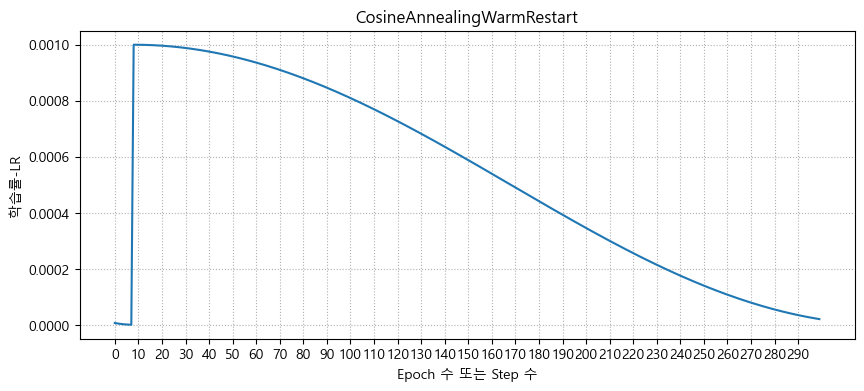

In [68]:
plot_lr("CosineAnnealingWarmRestart", lr_list3)